# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *\<Angelo Mandara\>*

**Matricola**: *\<2077139\>*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

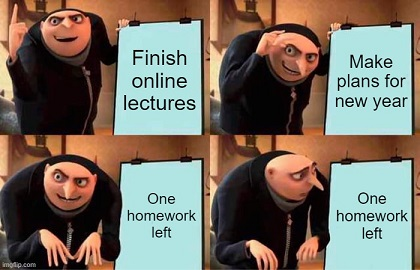

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

## Dataset Description
The dataset I've choose to use is the ["Twitter Financial News Topic"](https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic) on Hugging Face.

This dataset is designed for **topic classification tasks**, particularly in the domain of **financial news** as conveyed through Twitter.
It offers a wealth of information for evaluating and classifying financial news and trends since it comprises English-language tweets on a range of financial subjects. A variety of financial subjects, including "Analyst Update," "Fed | Central Banks," "Company | Product News," and so on (there are **20 classes**) are labelled for each tweet in the dataset. Because of this, the dataset is especially well-suited for training models that will automatically classify financial news according to their content.

The dataset is useful for anyone who want to build models for automatic news categorisation in the financial industry, analyse financial patterns, or comprehend market attitudes. The dataset also highlights the particular traits and difficulties of social media writing, such as informal language, hashtags, and abbreviations, because it is derived from Twitter.

There are 2 splits:
- **Train**	with 16,990 examples
- **Validation**	with 4,118 examples.

I observed that there is an imbalance in the dataset, with a considerably higher number of samples in some classes than in others. I decided to balance the classes with suitable weights since I thought that an imbalance might affect the model's performance and possibly cause it to forecast the majority class more frequently.

Furthermore, the majority of texts have a length of between 50 and 150 characters, with a distribution that peaks in the centre. This suggests that tweets—which frequently have a character limit—tend to be succinct and targeted. The tokenizer's `max_length` was chosen with consideration to this analysis.


### Bibliography:
- Already linked paper
- [LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS](https://arxiv.org/pdf/2106.09685.pdf) Hu et Al.
- [Youtube Video 1](https://www.youtube.com/watch?v=Us5ZFp16PaU&ab_channel=SamWitteveen)
- [Youtube Video 2](https://www.youtube.com/watch?v=dA-NhCtrrVE&ab_channel=ChrisAlexiuk)
- [Dataset](https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic)
- [Model](https://huggingface.co/yiyanghkust/finbert-tone)

In [3]:
# TODO: Insert all code here.
#Loading of all libraries used and of the dataset from Hugging Face
!pip install datasets
from datasets import load_dataset
from typing import Tuple, Dict, List, Union
from tensorflow.keras.callbacks import EarlyStopping
from transformers import TFBertModel, BertTokenizer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import re
from tensorflow.keras.layers import Dense, Dropout
import os
import pandas as pd
import seaborn as sns
dataset = load_dataset("zeroshot/twitter-financial-news-topic")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]

Number of training samples: 16990
Number of validation samples: 4117
Average text length: 135.61506768687462


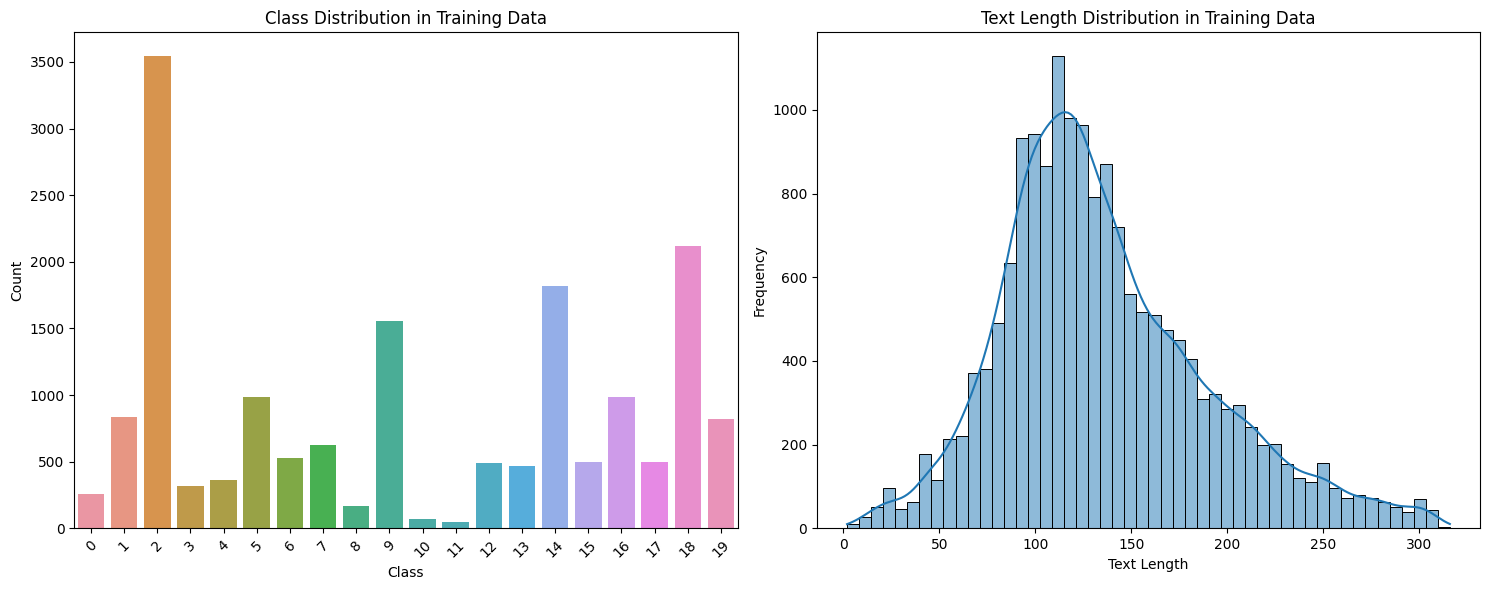

In [5]:
# Convert to Pandas DataFrame for class distribution analysis
train_df = pd.DataFrame(train_dataset)
validation_df = pd.DataFrame(validation_dataset)

print("Number of training samples:", len(train_df))
print("Number of validation samples:", len(validation_df))

# average text length
train_df["text_length"] = train_df["text"].apply(len)
avg_text_length = train_df["text_length"].mean()
print("Average text length:", avg_text_length)

# subplots for class distribution and text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# class Distribution
sns.countplot(x="label", data=train_df, ax=axes[0])
axes[0].set_title("Class Distribution in Training Data")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# text Length Distribution
sns.histplot(train_df["text_length"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Text Length Distribution in Training Data")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Preprocessing Steps:

1. **URL Replacement**: I used the special token `[URL]` to delete URLs that were present in the text. By eliminating the unpredictability brought about by unique URLs—which are unlikely to be helpful for topic classification—this step aids in the normalisation of the text data.

2. **Batch Processing**: The `preprocess` function is applied to the train and validation datasets in batches for efficiency. Batch processing speeds up the execution compared to processing each example individually.

### Tokenization:

For tokenization, we use the `BertTokenizer` from the 'yiyanghkust/finbert-tone' model. This tokenizer is specially trained for financial text and is expected to handle the domain-specific language effectively.

### Why 'yiyanghkust/finbert-tone' Tokenizer?

The choice of using the 'yiyanghkust/finbert-tone' tokenizer is motivated by the nature of our dataset:

- **Domain-Specific Vocabulary**: A tokenizer trained on related text is most effective in capturing the specific terminologies and expressions used in the financial news domain.

- **Consistency with Pretrained Models**: Using the same tokenizer is crucial for consistency if we wish to classify using the 'finbert-tone' pretrained model. Tokens generated by the tokenizer have to be identical to the tokens used to train the model.

### Dataset Preparation:

After preprocessing and tokenization, we prepare the TensorFlow datasets:

1. **Tokenization**: We tokenize the texts using the chosen tokenizer with padding and truncation to ensure a uniform length of 128 tokens.

2. **Conversion to Tensors**: Tokenized inputs are transformed into TensorFlow tensors so that neural network models can be fed into them.

3. **Dataset Object Creation**: Using the tokenized inputs and labels, we build TensorFlow `Dataset` objects. TensorFlow models may be trained effectively and conveniently with this format.

4. **Batching and Prefetching**: To increase training speed, we employ `prefetch` in conjunction with batched datasets of size 32. While the model is training, prefetching enables the data pipeline to fetch batches asynchronously.


These procedures guarantee that the dataset is clean, tokenized in accordance with domain-specific specifications, and prepared for effective deep learning model training.

In [19]:
# initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

def preprocess(examples):
    def clean_text(text):
        # I replace URLs with a special token
        text = re.sub(r'http\S+', '[URL]', text)
        return text

    examples["text"] = [clean_text(text) for text in examples["text"]]
    return examples

# apply now the preprocessing to train and validation datasets
dataset["train"] = dataset["train"].map(preprocess, batched=True)
dataset["validation"] = dataset["validation"].map(preprocess, batched=True)

def prepare_dataset(dataset):
    tokenized_inputs = tokenizer(dataset["text"], padding=True, truncation=True, max_length=128, return_tensors="tf")
    labels = tf.convert_to_tensor(dataset["label"])
    return tf.data.Dataset.from_tensor_slices(({"input_ids": tokenized_inputs["input_ids"],
                                                "attention_mask": tokenized_inputs["attention_mask"]},
                                               labels))


# prepare train and validation datasets
train_dataset = prepare_dataset(dataset['train'])
validation_dataset = prepare_dataset(dataset['validation'])

train_dataset = train_dataset.shuffle(10000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

## Extracting Labels and Computing Class Weights

In this section of the code, we perform the extraction of labels from the training dataset and subsequently compute class weights for imbalanced class distribution.



In [20]:
# Extract labels from the dataset
labels = []
for _, label in train_dataset.unbatch().take(-1):
    labels.append(label.numpy())
labels = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [21]:
#let's have a look
for example in train_dataset.take(1):  # Only take 1 batch for inspection
    input_ids, attention_mask, labels = example[0]["input_ids"], example[0]["attention_mask"], example[1]

    # convert the input_ids and attention_mask back to text for readability
    for i in range(input_ids.shape[0]):
        print("Text:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
        print("Attention mask:", attention_mask[i])
        print("Label:", labels[i])
        print("\n")
        break

Text: new vatican policy orders foreign investment accounts closed [ url ] [ url ]
Attention mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int32)
Label: tf.Tensor(9, shape=(), dtype=int32)




### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

`LoRADense` is a custom layer that is derived from tf.keras.layers.Layer. Its purpose is to include LoRA (Linearly-Refined Attention) into a layer that is thick.

By adding an improved attention mechanism (LoRA), LoRADense is a layer that expands on a conventional dense layer. The primary weights (W and b) are used to produce the initial output, to which a refined attention update is appended. This update adds dropout during training, which is determined by the rank parameter, and aims to improve the expressiveness of the layer.

In [ ]:
# TODO: Your code here.

In [10]:
class LoRADense(tf.keras.layers.Layer):
    '''
    This is a custom layer named LoRADense that inherits from tf.keras.layers.Layer.
    It is designed to integrate LoRA (Linearly-Refined Attention) into a dense layer.
    Parameters:
    units: The dimensionality of the output space.
    rank: The rank parameter for LoRA, controlling the number of parameters in the refined attention mechanism.
          The value of 4 is choosen accordingly to the paper.
    dropout_rate: The rate of dropout applied to the LoRA update during training.
    l2_lambda: The L2 regularization strength for the layer.
    '''
    def __init__(self, units, rank=4, dropout_rate=0.1, l2_lambda=0.01, **kwargs):
      # constructor method where the layer's parameters are initialized
        super(LoRADense, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    def build(self, input_shape):
      '''
      layer's weights are created. It defines three sets of weights:
      W: The primary weight matrix for the dense layer.
      b: The bias vector for the dense layer.
      W1 and W2: The weights for the LoRA mechanism.
      '''
      self.W = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='glorot_uniform',
                               regularizer=tf.keras.regularizers.l2(self.l2_lambda),
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='zeros',
                               trainable=True)
      self.W1 = self.add_weight(shape=(input_shape[-1], self.rank),
                                initializer='random_normal',
                                trainable=True)
      self.W2 = self.add_weight(shape=(self.rank, self.units),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs, training=False):
      # this method defines the layer's forward pass
        original_output = tf.matmul(inputs, self.W) + self.b
        lora_update = tf.matmul(inputs, self.W1)
        if training:
            lora_update = Dropout(self.dropout_rate)(lora_update)
        lora_update = tf.matmul(lora_update, self.W2)
        return original_output + lora_update

This is a custom model named `FinBERTLoRAModel_classic` that inherits from tf.keras.Model.

It incorporates the FinBERT pre-trained BERT model with an added LoRA layer and a classifier.
The added part `_classic` is because in this implementation all the weights of the pretrained model are freezed, updating only a very small percentage of parameters, but achieving not a high accuracy.
The [model](https://huggingface.co/yiyanghkust/finbert-tone) is taken from HugginFace, is a BERT model pre-trained on financial communication text and  is specially trained for financial text and is expected to handle the domain-specific language effectively.

In [23]:
class FinBERTLoRAModel_classic(tf.keras.Model):
    '''
    This is a classic version of the FinBERTLoRAModel, named FinBERTLoRAModel_classic,
    where the weights of the pre-trained BERT model are frozen.

    Parameters:
    num_classes: The number of output classes for classification.
    rank: The rank parameter for LoRA, controlling the number of parameters in the refined attention mechanism.

    Components:
    A pre-trained BERT model (TFBertModel) from 'yiyanghkust/finbert-tone' with trainable set to False.
    A dropout layer with a dropout rate of 0.1.
    A dense layer for final classification with num_classes output units.
    '''
    def __init__(self, num_classes, rank=4, **kwargs):
        super(FinBERTLoRAModel_classic, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('yiyanghkust/finbert-tone', trainable=False)

        self.lora_layer = LoRADense(self.bert.config.hidden_size, rank=rank)

        self.dropout = Dropout(0.1)
        self.classifier = Dense(num_classes)

    def call(self, inputs, training=False):
        '''
        method defines the forward pass of the model. It takes input IDs and attention mask as inputs,
        passes them through the frozen BERT model, extracts the pooled output, applies the LoRA layer,
        and finally passes it through dropout and the classifier for classification
        '''
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        # Apply the LoRA layer
        lora_output = self.lora_layer(pooled_output, training=training)

        lora_output = self.dropout(lora_output, training=training)
        final_output = self.classifier(lora_output)
        return final_output


In [ ]:
# instantiation of the model
num_classes = 20
lora_rank = 4           #in the paper is shown that low value of r take to same value of accuracy more or less

model_classic = FinBERTLoRAModel_classic(num_classes=num_classes, rank=lora_rank)

#a low learning rate is choosen since in fine tuning task is important to not overshoot
#from the 'considered' smooth area where the pretrained model arrived
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_classic.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# define an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# fit the model
history_classic = model_classic.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
531/531 [==============================] - 215s 379ms/step - loss: 10.3846 - accuracy: 0.1434 - val_loss: 9.9846 - val_accuracy: 0.2747
Epoch 2/20
531/531 [==============================] - 201s 379ms/step - loss: 9.7059 - accuracy: 0.3129 - val_loss: 9.4354 - val_accuracy: 0.3692
Epoch 3/20
531/531 [==============================] - 200s 376ms/step - loss: 9.2178 - accuracy: 0.3855 - val_loss: 8.9804 - val_accuracy: 0.4384
Epoch 4/20
531/531 [==============================] - 203s 381ms/step - loss: 8.8245 - accuracy: 0.4393 - val_loss: 8.6275 - val_accuracy: 0.4651
Epoch 5/20
531/531 [==============================] - 202s 380ms/step - loss: 8.4610 - accuracy: 0.4685 - val_loss: 8.3137 - val_accuracy: 0.4950
Epoch 6/20
531/531 [==============================] - 197s 371ms/step - loss: 8.1457 - accuracy: 0.4951 - val_loss: 7.9965 - val_accuracy: 0.5196
Epoch 7/20
531/531 [==============================] - 197s 371ms/step - loss: 7.8479 - accuracy: 0.5157 - val_loss: 7.7470 

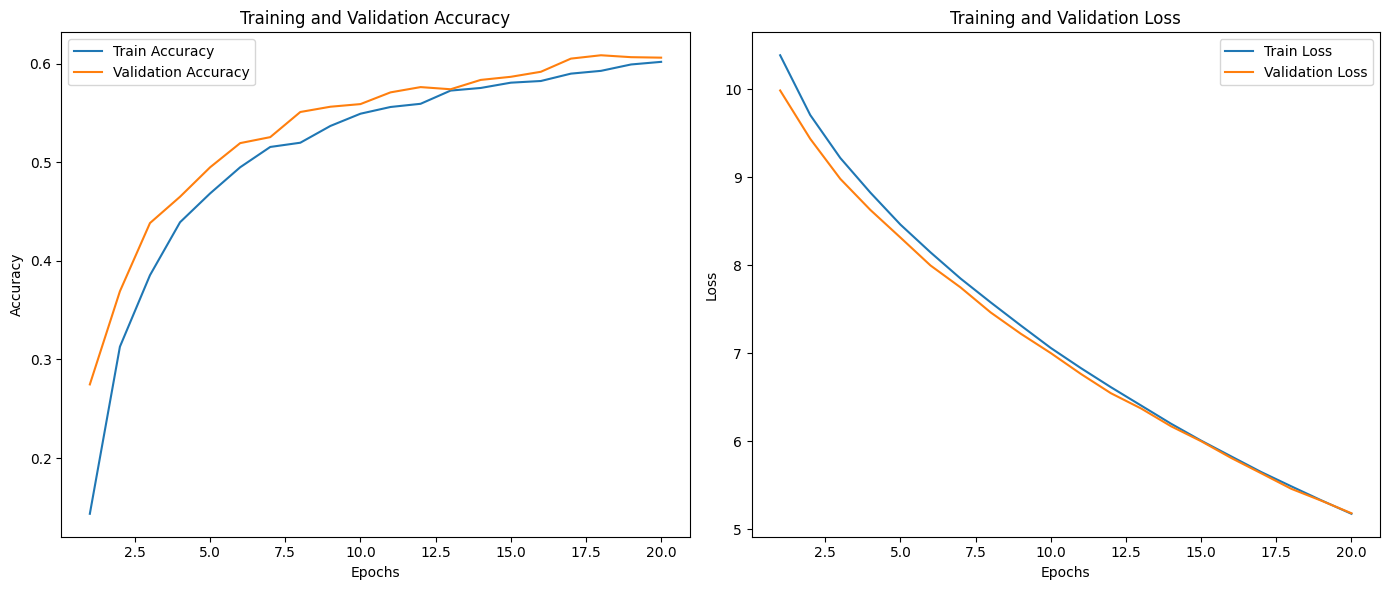

In [ ]:
# we extract accuracy and loss values from the history
train_accuracy = history_classic.history['accuracy']
val_accuracy = history_classic.history['val_accuracy']
train_loss = history_classic.history['loss']
val_loss = history_classic.history['val_loss']

# create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# create a Seaborn plot with two subplots (one for accuracy and one for loss)
plt.figure(figsize=(14, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_accuracy, label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')

# Subplot for loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_loss, label='Train Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [ ]:
model_classic.summary()

Model: "fin_bert_lo_ra_model_classic_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_3 (TFBertMod  multiple                  109751808 
 el)                                                             
                                                                 
 lo_ra_dense_3 (LoRADense)   multiple                  596736    
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  15380     
                                                                 
Total params: 110363924 (421.00 MB)
Trainable params: 612116 (2.34 MB)
Non-trainable params: 109751808 (418.67 MB)
_________________________________________________________________


As shown the percentange of updated parameters are very small, but accuracy poor, in the next cell there is the implementation of the `FinBERTLoRAModel`, but allowing the update of a part of the pretrained weights, I added so an other parameter `unfreeze_layers`, that indicate the number of the last layers to update.

With this modification(that is used also in this [paper](https://arxiv.org/pdf/2106.09685.pdf)) the accuracy is boosted, arriving to a value of 0.89.

In [ ]:
class FinBERTLoRAModel(tf.keras.Model):
    '''
    This is an updated version of the FinBERTLoRAModel, named FinBERTLoRAModel,
    where a percentage of the weights of the pre-trained BERT model are frozen.
    Modifying the parameter _unfreeze_layers_ will change this percentage.

    Parameters:
    num_classes: The number of output classes for classification.
    rank: The rank parameter for LoRA, controlling the number of parameters in the refined attention mechanism.
    unfreeze_layers: The number of layers of the pretrained model to unfreeze.

    Components:
    A pre-trained BERT model (TFBertModel) from 'yiyanghkust/finbert-tone' with trainable set to False.
    A dropout layer with a dropout rate of 0.1.
    A dense layer for final classification with num_classes output units.
    '''
    def __init__(self, num_classes, rank=4, unfreeze_layers=5, **kwargs):
        super(FinBERTLoRAModel, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('yiyanghkust/finbert-tone')

        # Set BERT layers to non-trainable
        self.set_bert_layers_trainable(False)

        # Unfreeze the last 'unfreeze_layers' of BERT's encoder layers
        self.set_bert_layers_trainable(True, last_n_layers=unfreeze_layers)

        # Initialize one LoRA layer
        self.lora_layer = LoRADense(self.bert.config.hidden_size, rank=rank)

        self.dropout = Dropout(0.1)
        self.classifier = Dense(num_classes)

    def set_bert_layers_trainable(self, trainable, last_n_layers=None):
        if last_n_layers is not None:
            # Unfreeze only the last 'last_n_layers' layers
            for layer in self.bert.bert.encoder.layer[-last_n_layers:]:
                layer.trainable = trainable
        else:
            # Set all BERT layers as trainable/non-trainable
            for layer in self.bert.bert.encoder.layer:
                layer.trainable = trainable

    def call(self, inputs, training=False):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        # Apply the LoRA layer
        lora_output = self.lora_layer(pooled_output, training=training)

        lora_output = self.dropout(lora_output, training=training)
        final_output = self.classifier(lora_output)
        return final_output


In [ ]:
# we have to set the new parameter
unfreeze_layers_true = 3
# instantiate and compile the model as before
model = FinBERTLoRAModel(num_classes=num_classes, rank=lora_rank, unfreeze_layers=unfreeze_layers_true)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # same motivation as before
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# Fit the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
531/531 [==============================] - 420s 737ms/step - loss: 9.1704 - accuracy: 0.5013 - val_loss: 8.5042 - val_accuracy: 0.6811
Epoch 2/20
531/531 [==============================] - 388s 731ms/step - loss: 7.9136 - accuracy: 0.7377 - val_loss: 7.8396 - val_accuracy: 0.7722
Epoch 3/20
531/531 [==============================] - 388s 730ms/step - loss: 7.3730 - accuracy: 0.8034 - val_loss: 7.3945 - val_accuracy: 0.8013
Epoch 4/20
531/531 [==============================] - 392s 739ms/step - loss: 6.8954 - accuracy: 0.8390 - val_loss: 6.9615 - val_accuracy: 0.8108
Epoch 5/20
531/531 [==============================] - 393s 740ms/step - loss: 6.4078 - accuracy: 0.8638 - val_loss: 6.4165 - val_accuracy: 0.8448
Epoch 6/20
531/531 [==============================] - 388s 731ms/step - loss: 5.8986 - accuracy: 0.8864 - val_loss: 5.9701 - val_accuracy: 0.8402
Epoch 7/20
531/531 [==============================] - 392s 738ms/step - loss: 5.3770 - accuracy: 0.9026 - val_loss: 5.4388 -

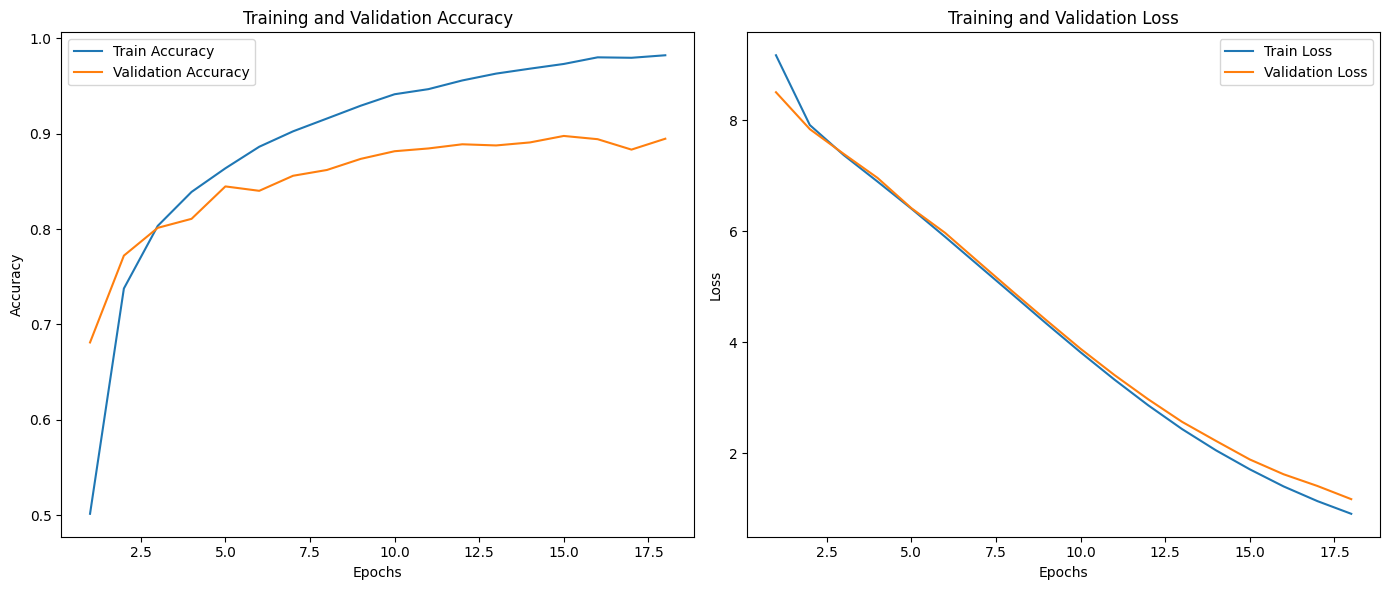

In [ ]:
# we extract accuracy and loss values from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# create a Seaborn plot with two subplots (one for accuracy and one for loss)
plt.figure(figsize=(14, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_accuracy, label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')

# Subplot for loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_loss, label='Train Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [ ]:
model.summary()

Model: "fin_bert_lo_ra_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_4 (TFBertMod  multiple                  109751808 
 el)                                                             
                                                                 
 lo_ra_dense_4 (LoRADense)   multiple                  596736    
                                                                 
 dropout_189 (Dropout)       multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  15380     
                                                                 
Total params: 110363924 (421.00 MB)
Trainable params: 46573076 (177.66 MB)
Non-trainable params: 63790848 (243.34 MB)
_________________________________________________________________


With this implemenation and this choise of parameters an accuracy of 0.89 is achieved, using approximately 40% of the total parameters and 177.66MB, that can be relatevely few.

In [ ]:
#same print of the correctness of the procedure
print("Example data:", dataset['validation'][0])

example = dataset['validation'][0]['text']
tokenized_example = tokenizer(example, padding=True, truncation=True, max_length=128, return_tensors="tf")
print("Tokenized example:", tokenized_example)

# prepare a small part of the dataset for testing
small_val_dataset = prepare_dataset(dataset['validation'][:10])

for inputs, labels in small_val_dataset.take(1):
    print("Inputs:", inputs)
    print("Input shapes:", {k: v.shape for k, v in inputs.items()})
    print("Labels:", labels)
    print("Label shape:", labels.shape)

# running the model on a single batch
for inputs, labels in small_val_dataset.batch(1).take(1):
    try:
        predictions = model(inputs)
        print("Predictions:", predictions)
    except Exception as e:
        print("Error during model prediction:", e)

# apply softmax to convert logits to probabilities
probabilities = tf.nn.softmax(predictions, axis=1)
print("Probabilities:", probabilities)
# get the class with the highest probability
chosen_class = tf.argmax(probabilities, axis=1)
print("Chosen class:", chosen_class.numpy())

Example data: {'text': 'Analyst call of the day for @CNBCPro subscribers: Goldman Sachs reiterates Exxon as buy and says it’s bullish heading into earnings next week.  Subscribe to see the analyst calls of the day curated by CNBC Pro.  [URL]', 'label': 0}
Tokenized example: {'input_ids': <tf.Tensor: shape=(1, 53), dtype=int32, numpy=
array([[    3,   508,   347,     7,     6,  1037,    14, 17039,  6527,
         8225,  3987,  2826,  3108,  2485,  4549,  3247,    63, 16003,
           18,   500,     8,  8276,    41, 30748,    58,  5945,  4555,
          119,   149,   165,  1952,    48,  9356,     9,   153,     6,
          508,  2602,     7,     6,  1037, 25262,  3095,    24,  6527,
         8225,  1547,    48,  4249,  8270,   604,  7115,     4]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 53), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

## INFERENCE
Now it's time to use the fine-tuned model to real application.
I searched for some article online, mainly on **Cncb** and **Reuters** to check if the model is functioning correctly.

In [ ]:
#actual label of the dataset
topics = {
    "LABEL_0": "Analyst Update",
    "LABEL_1": "Fed | Central Banks",
    "LABEL_2": "Company | Product News",
    "LABEL_3": "Treasuries | Corporate Debt",
    "LABEL_4": "Dividend",
    "LABEL_5": "Earnings",
    "LABEL_6": "Energy | Oil",
    "LABEL_7": "Financials",
    "LABEL_8": "Currencies",
    "LABEL_9": "General News | Opinion",
    "LABEL_10": "Gold | Metals | Materials",
    "LABEL_11": "IPO",
    "LABEL_12": "Legal | Regulation",
    "LABEL_13": "M&A | Investments",
    "LABEL_14": "Macro",
    "LABEL_15": "Markets",
    "LABEL_16": "Politics",
    "LABEL_17": "Personnel Change",
    "LABEL_18": "Stock Commentary",
    "LABEL_19": "Stock Movement",
}

In [ ]:
examples = [
    'Sterling surges on better-than-expected PMI, consumer credit https://www.reuters.com/markets/currencies/sterling-surges-better-than-expected-pmi-consumer-credit-2024-01-04/#:~:text=LONDON%2C%20Jan%204%20(Reuters),resilient%20than%20feared%20economic%20picture.',
    'Stocks making the biggest moves midday: Xerox, SoFi, Charles Schwab and more https://www.cnbc.com/2024/01/03/stocks-making-the-biggest-moves-midday-xrx-sofi-schw.html',
    'Stocks making the biggest moves midday: Moderna, Apple, GoodRx and more https://www.cnbc.com/2024/01/02/stocks-making-the-biggest-moves-midday-mrna-aapl-gdrx-coin.html',
    'Deadly Iran blasts and Red Sea attacks deepen fears of a wider Middle East war https://www.cnbc.com/2024/01/04/iran-blasts-and-red-sea-attacks-stoke-fears-of-a-wider-middle-east-war.html',
    'Deutsche Bank names the stock that’ll be the ‘last man standing’ in autonomous driving https://www.cnbc.com/2024/01/04/deutsche-bank-names-stock-seen-as-last-man-standing-in-driverless-tech.html',
    'USD drags down gold and silver prices https://www.kitco.com/news/article/2024-01-03/gold-silver-smacked-bounce-greenback-profit-taking',
    'Trump seeks to hold special counsel in contempt for violating pause in election case https://www.reuters.com/legal/trump-seeks-hold-special-counsel-contempt-violating-pause-election-case-2024-01-04/',
    'Suraj Estate shares debut on Dalal Street at ₹340 apiece https://www.cnbctv18.com/market/suraj-estate-ipo-listing-date-today-debut-bse-nse-issue-price-18642491.htm'
]

for example_text in examples:
    # Tokenize the text
    tokenized_example = tokenizer.encode_plus(
        example_text,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # Make a prediction
    with tf.device('/cpu:0'):  # Use CPU for inference
        prediction = model.predict({
            'input_ids': tokenized_example['input_ids'],
            'attention_mask': tokenized_example['attention_mask']
        })

    # Interpret the result
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = topics[f"LABEL_{predicted_class_index}"]
    print(f"Example: '{example_text}'")
    print(f"Predicted Topic: {predicted_class_label}\n")


1/1 [==============================] - 1s 636ms/step
Example: 'Sterling surges on better-than-expected PMI, consumer credit https://www.reuters.com/markets/currencies/sterling-surges-better-than-expected-pmi-consumer-credit-2024-01-04/#:~:text=LONDON%2C%20Jan%204%20(Reuters),resilient%20than%20feared%20economic%20picture.'
Predicted Topic: Currencies

1/1 [==============================] - 1s 652ms/step
Example: 'Stocks making the biggest moves midday: Xerox, SoFi, Charles Schwab and more https://www.cnbc.com/2024/01/03/stocks-making-the-biggest-moves-midday-xrx-sofi-schw.html'
Predicted Topic: Stock Movement

1/1 [==============================] - 1s 664ms/step
Example: 'Stocks making the biggest moves midday: Moderna, Apple, GoodRx and more https://www.cnbc.com/2024/01/02/stocks-making-the-biggest-moves-midday-mrna-aapl-gdrx-coin.html'
Predicted Topic: Stock Movement

1/1 [==============================] - 1s 619ms/step
Example: 'Deadly Iran blasts and Red Sea attacks deepen fears of

Everything seems to work perfectly!

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

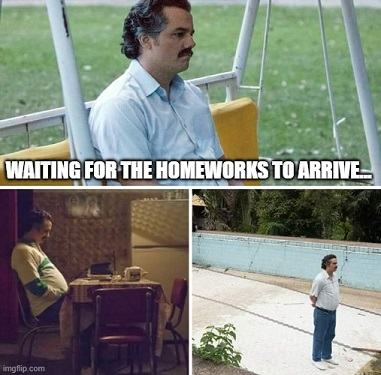